<a href="https://colab.research.google.com/github/jdwatson08/House_Price_Prediction_Model/blob/main/House_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import chi2_contingency
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!unzip \*.zip && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
!ls

 2023-01-07_2015_submission.csv   onehr.data
 Chronic_Kidney_Disease.rar	  predictions.csv
 data_description.txt		  README.docx
 dataset.gsheet			  sample_submission.csv
 gender_submission.csv		  submission.csv
 heart.csv			  test.csv
 house_test			  test_features.csv
 house_train			  train.csv
 __MACOSX			  train_features.csv
 model_rf_rs_80			  train_labels.csv
 ndtv_data_final.csv		 'Untitled document.gdoc'
 o2Saturation.csv		  water_potability.csv


In [ ]:
def wrangle(filename):
  df =pd.read_csv(filename, index_col='Id')

  #Remove columns with majority null values
  threshold = 1000
  null_cols =[]
  for col in df:
    if df[col].isnull().sum() > threshold:
      null_cols.append(col)

  df.drop(columns= null_cols, inplace=True)


  #Remove columns with only 1 value
  one_val =[]
  for col in df:
    if df[col].nunique()==1:
      one_val.append(col)

  df.drop(columns=one_val, inplace=True)



  return df

In [ ]:
df = wrangle('house_train')
house_test = wrangle("house_test")

In [ ]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [ ]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

# Target is Right Skewed

# Define Feature Matrix and Target array

In [ ]:
target= 'SalePrice'
X = df.drop(columns=target)
y=df[target]

log_y = np.log(y)

<Axes: >

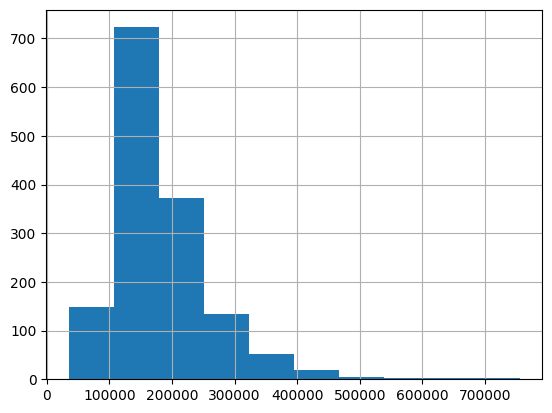

In [ ]:
df['SalePrice'].hist()

## Test for normal distribution

In [ ]:
from scipy import stats

_, p = stats.normaltest(y)
print(p)

2.283848353787728e-133


# Target needs to be transformed with log function

<Axes: >

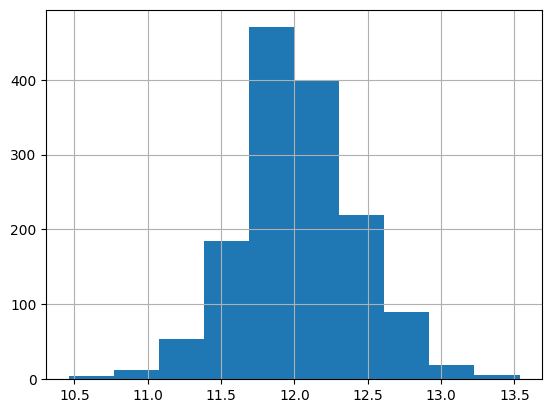

In [ ]:
log_sale=np.log(df['SalePrice'])
log_sale.hist()

## Target is a lot closer to normal distribution now

In [ ]:
from scipy import stats

_, p = stats.normaltest(log_y)
print(p)

2.89216582205235e-06


# Baseline

In [ ]:
y_log_pred = [y.mean()]*len(y)
baseline_mae = mean_absolute_error(log_y, y_log_pred)
print("The baseline mae:",baseline_mae)

The baseline mae: 180909.17183950983


# Split Data

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X, log_y, test_size=0.1, random_state=42)

# Model

In [ ]:
model_lr = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='median'),
    LinearRegression()
)

model_lr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [ ]:
print("The model score is:",model_lr.score(X_val,y_val))
print("The model mae is:", mean_absolute_error(y_val, model_lr.predict(X_val)))

The model score is: 0.8807645312408002
The model mae is: 0.1095956076631455


# Model 2 is slightly better

In [ ]:
model_r = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='median'),
    Ridge()
)

model_r.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('ridge', Ridge())])

In [ ]:
print("The model score is:",model_r.score(X_val,y_val))
print("The model mae is:", mean_absolute_error(y_val, model_r.predict(X_val)))

The model score is: 0.8869143464526865
The model mae is: 0.10688018221974004


In [ ]:
model_predictions =  model_r.predict(X_val)

# Model Predictions vs Validation Data Visualization



Text(0.5, 1.0, 'Training Data Price')

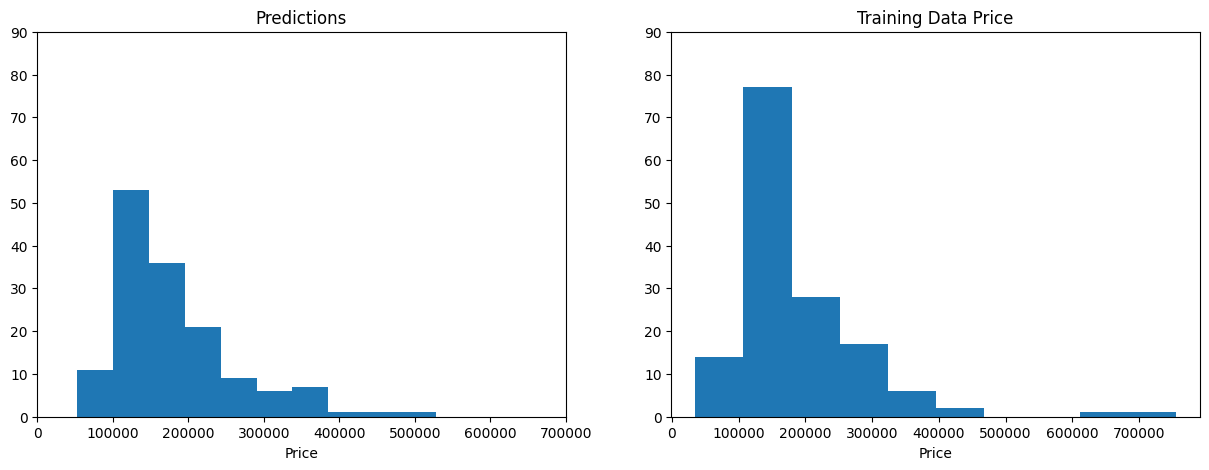

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Sale Price Prediction vs Actual")
ax1.hist(np.exp(pd.DataFrame(model_predictions)))
ax1.set_xlabel("Price")
ax1.set_yticks(np.arange(0, 100, 10))
ax1.set_xticks(np.arange(0,800000,100000))
ax1.set_title("Predictions")

ax2.hist(np.exp(y_val))
ax2.set_xlabel("Price")
ax2.set_yticks(np.arange(0, 100, 10))
ax2.set_xticks(np.arange(0,800000,100000))
ax2.set_title("Training Data Price")

# Feature Permutation

In [ ]:
perm_imp = permutation_importance(model_r,X,log_y, random_state=42)

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [ ]:
display(df_perm)

,imp_mean,imp_std
LandSlope,-0.000026,0.000011
Utilities,0.000013,0.000004
Street,0.000039,0.000020
Condition2,0.000044,0.000090
BsmtHalfBath,0.000076,0.000020
...,...,...
TotRmsAbvGrd,0.021407,0.001164
FullBath,0.024936,0.001156
Neighborhood,0.025097,0.001186
GarageCars,0.025166,0.001532


# Predictions for Kaggle test file

In [ ]:
house_test['Utilities'] ='AllPub'

In [ ]:
house_test = house_test[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']]

## Predict values and inverse log to get true values

In [ ]:
predictions = pd.DataFrame(np.exp(model_r.predict(house_test)))

In [ ]:
predictions.rename(columns={0:"SalePrice"},inplace=True)
predictions = predictions['SalePrice'].astype('int')

In [ ]:
predictions = pd.DataFrame(predictions)

In [ ]:
predictions.to_csv("predictions.csv", index = False)
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
predictions

,SalePrice
0,124235
1,145807
2,181929
3,199794
4,198657
...,...
1454,80234
1455,77085
1456,162203
1457,114541
